Import das bibliotecas necessárias para execução e criação dos modelos

In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [30]:
n_variate = 1

In [31]:
#Load dataset
def load_dataset(path=r'./Datasets_utilizados/dataset_final.csv'):
  return pd.read_csv(path)

In [32]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [33]:
def prepare_data(df):
  df_aux = df.copy()
  df_aux["Date"] = pd.to_datetime(df_aux["Date"])
  df_aux = df_aux.set_index('Date')
  return df_aux

In [34]:
# def data_normalization(df, norm_range=(-1, 1)):
#   #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
#   scaler = MinMaxScaler(feature_range=norm_range)
#   df = scaler.fit_transform(df)
#   return scaler

In [35]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  colunas = [x for x in df.columns if x != 'obitos']
  for col in colunas:
    df[[col]] = scaler.fit_transform(df[[col]])
  df[['obitos']] = scaler.fit_transform(df[['obitos']])
  return scaler

In [36]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  # plt.plot(epochs_range,mae,label='Training MAE')
  # plt.plot(epochs_range,val_mae,label='Validation MAE')
  # plt.plot(epochs_range,rmse,label='Training RMSE')
  # plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [37]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [38]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 76])
      # y.append(data[input_index:label_index, 0:n_variate])

  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [39]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [40]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
    #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  # model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'Covid_model.png', show_shapes=True)
  return model

In [41]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size, learning_rate):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False)
    # history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [42]:
#Main Execution
#the dataframes
df_raw = load_dataset()
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)

scaler = data_normalization(df) #scaling data to [-1, 1]

In [43]:
df

,confirmados_novos,recuperados,Temperature,Visibility,total_testes,testes_pcr,testes_antigenio,new_cases_per_million_Austria,new_deaths_per_million_Austria,new_cases_per_million_Belgium,new_deaths_per_million_Belgium,icu_patients_per_million_Belgium,hosp_patients_per_million_Belgium,new_deaths_per_million_Bulgaria,new_cases_per_million_Canada,new_deaths_per_million_Canada,icu_patients_per_million_Canada,new_cases_per_million_Cyprus,new_deaths_per_million_Czechia,hosp_patients_per_million_Czechia,new_cases_per_million_Denmark,new_tests_per_thousand_Estonia,icu_patients_per_million_France,new_cases_per_million_Georgia,new_cases_per_million_Germany,new_deaths_per_million_Germany,icu_patients_per_million_Germany,new_deaths_per_million_Hungary,hosp_patients_per_million_Hungary,positive_rate_India,new_cases_per_million_Ireland,new_deaths_per_million_Ireland,icu_patients_per_million_Ireland,hosp_patients_per_million_Ireland,new_tests_per_thousand_Ireland,positive_rate_Ireland,new_tests_per_thousand_Italy,new_cases_per_million_Japan,new_deaths_per_million_Japan,new_cases_per_million_Latvia,new_deaths_per_million_Latvia,hosp_patients_per_million_Latvia,new_tests_per_thousand_Latvia,new_cases_per_million_Lithuania,new_tests_per_thousand_Lithuania,icu_patients_per_million_Luxembourg,new_deaths_per_million_Malta,new_tests_per_thousand_Malta,positive_rate_Malta,new_cases_per_million_Monaco,new_cases_per_million_Montenegro,positive_rate_Mozambique,new_deaths_per_million_Poland,positive_rate_Romania,new_cases_per_million_Russia,new_deaths_per_million_Russia,new_deaths_per_million_Serbia,positive_rate_Serbia,new_cases_per_million_Slovakia,new_tests_per_thousand_Slovakia,new_cases_per_million_Slovenia,new_deaths_per_million_Slovenia,icu_patients_per_million_Slovenia,new_tests_per_thousand_Slovenia,new_deaths_per_million_Switzerland,new_cases_per_million_Turkey,positive_rate_Ukraine,new_deaths_per_million_United Arab Emirates,tests_per_case_United Arab Emirates,new_cases_per_million_United Kingdom,new_deaths_per_million_United Kingdom,icu_patients_per_million_United Kingdom,hosp_patients_per_million_United Kingdom,positive_rate_United Kingdom,new_cases_per_million_United States,new_deaths_per_million_United States,obitos
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-26,-1.000000,-1.000000,-0.454545,0.861111,-1.000000,-1.000000,-1.000000,-1.000000,-0.990870,-1.000000,-0.618279,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.964509,-0.979876,-1.000000,-0.385160,-1.000000,-1.000000,-0.999633,-0.999675,-0.964872,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.955538,-1.000000,-1.000000,-1.000000,-1.000000,-0.772353,-0.997456,-0.991874,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.555534,-0.981057,-1.000000,-0.578948,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.927693,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.993798,-0.234644,-1.000000,-1.000000,-1.000000,0.283484,-0.868730,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
2020-02-27,-1.000000,-1.000000,-0.333333,0.722222,-1.000000,-1.000000,-1.000000,-0.999791,-0.990870,-1.000000,-0.618279,-1.000000,-1.000000,-1.000000,-0.999752,-1.000000,-1.000000,-0.964509,-0.979876,-1.000000,-0.384852,-0.999440,-0.999422,-1.000000,-0.999306,-0.964872,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.955538,-1.000000,-1.000000,-1.000000,-1.000000,-0.765541,-0.995652,-0.983748,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.555534,-0.996100,-1.000000,-0.578948,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.927693,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.993282,-0.234644,-1.000000,-1.000000,-1.000000,0.190274,-0.868620,-1.000000,-1.000000,-1.000000,-1.000000,-0.999993,-1.000000,-1.000000
2020-02-28,-1.000000,-1.000000,-0.424242,0.250000,-1.000000,-1.000000,-1.000000,-1.000000,-0.990870,-1.000000,-0.6182

In [44]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    # se for necessário prever mais do que 1 semana
    # list_yhat = [yhat[0][i] for i in range(len(yhat[0]))]
    # print('list_yhat:')
    # print(list_yhat)
    # #preparar novo input para fazer previsão para a semana seguinte
    # inp= np.append(inp[0],[list_yhat],axis=0) #adiciona previsão recente ao input
    # inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
    # print('forecasts:')
    # print(forecasts)
  return forecasts



In [45]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(20,8))
  plt.plot(range(len(data)), data['obitos'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Óbitos em Portugal')
  plt.ylabel('Número de Óbitos')
  plt.xlabel('Semanas')
  plt.legend()
  plt.show()

# Tunning

In [46]:
tunning_dict = {               
                1: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 25,  'batch_size' : 1 , "learning_rate":0.001},
                2: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 2 ,"learning_rate":0.0001},
                3: {'timesteps' : 1, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 3 ,"learning_rate":0.00001},

                
                4: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 1 ,"learning_rate":0.001},
                5: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                6: {'timesteps' : 2, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001},
                
                7: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 1 ,"learning_rate":0.001},
                8: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 2 ,"learning_rate":0.0001},
                9: {'timesteps' : 4, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 3 ,"learning_rate":0.00001}

                }
# record da history de cada modelo
record = {}

Epoch 1/25
94/94 [==============================] - 4s 12ms/step - loss: 0.2725 - mae: 0.2589 - rmse: 0.2725 - val_loss: 0.0451 - val_mae: 0.0445 - val_rmse: 0.0451
Epoch 2/25
94/94 [==============================] - 0s 3ms/step - loss: 0.0285 - mae: 0.0273 - rmse: 0.0285 - val_loss: 0.0204 - val_mae: 0.0183 - val_rmse: 0.0204
Epoch 3/25
94/94 [==============================] - 0s 3ms/step - loss: 0.0213 - mae: 0.0208 - rmse: 0.0213 - val_loss: 0.0367 - val_mae: 0.0365 - val_rmse: 0.0367
Epoch 4/25
94/94 [==============================] - 0s 3ms/step - loss: 0.0270 - mae: 0.0261 - rmse: 0.0270 - val_loss: 0.0391 - val_mae: 0.0388 - val_rmse: 0.0391
Epoch 5/25
94/94 [==============================] - 0s 3ms/step - loss: 0.0302 - mae: 0.0293 - rmse: 0.0302 - val_loss: 0.0451 - val_mae: 0.0450 - val_rmse: 0.0451
Epoch 6/25
94/94 [==============================] - 0s 3ms/step - loss: 0.0282 - mae: 0.0273 - rmse: 0.0282 - val_loss: 0.0185 - val_mae: 0.0170 - val_rmse: 0.0185
Epoch 7/25
94/9

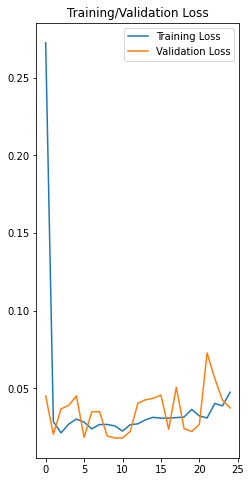

Epoch 1/25
189/189 [==============================] - 1s 3ms/step - loss: 0.0354 - mae: 0.0346 - rmse: 0.0354 - val_loss: 0.0146 - val_mae: 0.0139 - val_rmse: 0.0146
Epoch 2/25
189/189 [==============================] - 1s 3ms/step - loss: 0.0364 - mae: 0.0356 - rmse: 0.0364 - val_loss: 0.0285 - val_mae: 0.0284 - val_rmse: 0.0285
Epoch 3/25
189/189 [==============================] - 1s 3ms/step - loss: 0.0365 - mae: 0.0357 - rmse: 0.0365 - val_loss: 0.0132 - val_mae: 0.0131 - val_rmse: 0.0132
Epoch 4/25
189/189 [==============================] - 1s 3ms/step - loss: 0.0281 - mae: 0.0274 - rmse: 0.0281 - val_loss: 0.0127 - val_mae: 0.0116 - val_rmse: 0.0127
Epoch 5/25
189/189 [==============================] - 1s 3ms/step - loss: 0.0286 - mae: 0.0279 - rmse: 0.0286 - val_loss: 0.0122 - val_mae: 0.0115 - val_rmse: 0.0122
Epoch 6/25
189/189 [==============================] - 1s 3ms/step - loss: 0.0366 - mae: 0.0357 - rmse: 0.0366 - val_loss: 0.0136 - val_mae: 0.0126 - val_rmse: 0.0136
Epoc

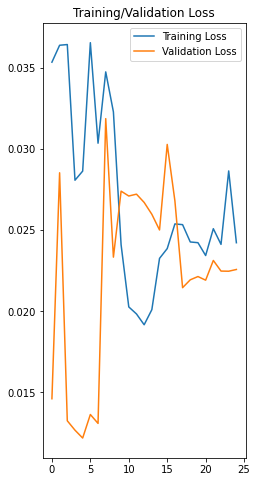

Epoch 1/25
283/283 [==============================] - 1s 3ms/step - loss: 0.0321 - mae: 0.0313 - rmse: 0.0321 - val_loss: 0.1070 - val_mae: 0.1054 - val_rmse: 0.1070
Epoch 2/25
283/283 [==============================] - 1s 3ms/step - loss: 0.0426 - mae: 0.0412 - rmse: 0.0426 - val_loss: 0.1042 - val_mae: 0.1035 - val_rmse: 0.1042
Epoch 3/25
283/283 [==============================] - 1s 3ms/step - loss: 0.0293 - mae: 0.0284 - rmse: 0.0293 - val_loss: 0.0684 - val_mae: 0.0678 - val_rmse: 0.0684
Epoch 4/25
283/283 [==============================] - 1s 3ms/step - loss: 0.0290 - mae: 0.0281 - rmse: 0.0290 - val_loss: 0.0739 - val_mae: 0.0734 - val_rmse: 0.0739
Epoch 5/25
283/283 [==============================] - 1s 3ms/step - loss: 0.0299 - mae: 0.0291 - rmse: 0.0299 - val_loss: 0.0694 - val_mae: 0.0691 - val_rmse: 0.0694
Epoch 6/25
283/283 [==============================] - 1s 3ms/step - loss: 0.0318 - mae: 0.0309 - rmse: 0.0318 - val_loss: 0.0707 - val_mae: 0.0703 - val_rmse: 0.0707
Epoc

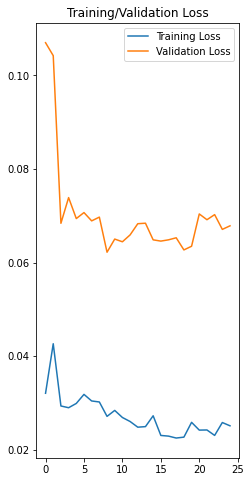

[array([[36.973686, 36.471703, 37.827847, 38.67971 , 35.025505, 37.886253,
        35.780014, 34.82522 , 36.86108 , 36.851818, 36.70327 , 38.4944  ,
        34.24671 , 37.19536 , 35.16543 , 37.024826, 36.544197, 36.532097,
        37.07022 , 37.665447, 36.887394, 37.685745, 37.53312 , 36.75387 ,
        36.50592 , 37.047646, 35.99607 , 38.695023, 37.08713 , 36.77939 ,
        36.82238 , 37.384502, 35.35839 , 36.44089 , 37.440968, 37.753113,
        36.99906 , 35.19169 , 36.980747, 33.694027, 38.431896, 35.391712,
        36.38971 , 36.930325, 37.852787, 35.822655, 36.430607, 35.858955,
        37.20512 , 37.075817, 36.868073, 40.5927  , 35.79867 , 36.407265,
        37.263897, 37.31747 , 36.175823, 37.016273, 34.692204, 36.189224,
        37.62613 , 36.112812, 34.60587 , 39.07082 , 38.828316, 35.6541  ,
        37.431515, 34.77176 , 35.11586 , 34.81067 , 37.26148 , 37.08322 ,
        36.958317, 37.05953 , 34.549915, 37.80417 , 36.244415]],
      dtype=float32)]
Previsões:
[36.973686]


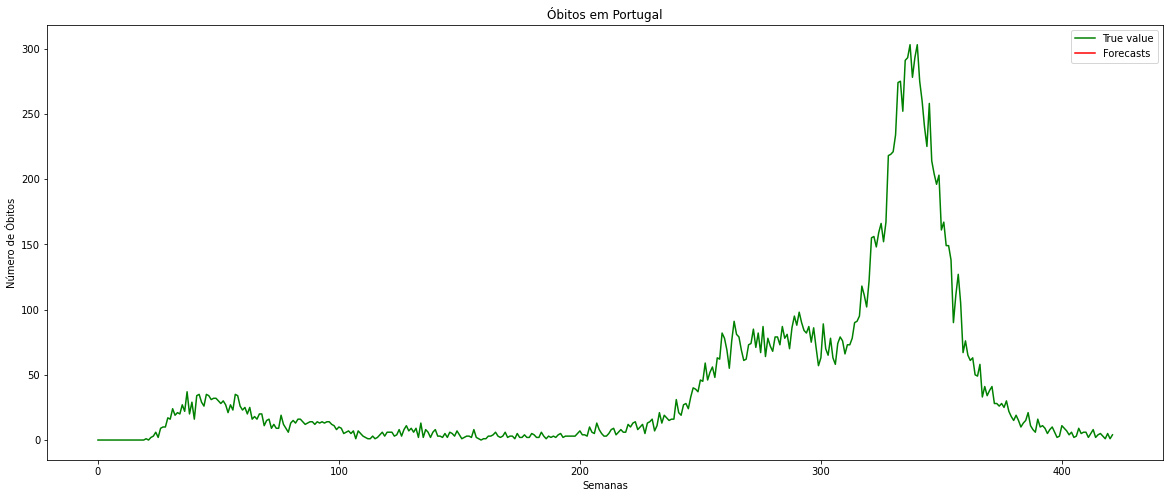

Epoch 1/50
47/47 [==============================] - 4s 19ms/step - loss: 0.8799 - mae: 0.8787 - rmse: 0.8799 - val_loss: 0.8978 - val_mae: 0.8954 - val_rmse: 0.8978
Epoch 2/50
47/47 [==============================] - 0s 4ms/step - loss: 0.8151 - mae: 0.8078 - rmse: 0.8151 - val_loss: 0.7875 - val_mae: 0.7708 - val_rmse: 0.7875
Epoch 3/50
47/47 [==============================] - 0s 4ms/step - loss: 0.6489 - mae: 0.6052 - rmse: 0.6489 - val_loss: 0.5512 - val_mae: 0.4665 - val_rmse: 0.5512
Epoch 4/50
47/47 [==============================] - 0s 4ms/step - loss: 0.4165 - mae: 0.3251 - rmse: 0.4165 - val_loss: 0.3274 - val_mae: 0.2346 - val_rmse: 0.3274
Epoch 5/50
47/47 [==============================] - 0s 4ms/step - loss: 0.2339 - mae: 0.1524 - rmse: 0.2339 - val_loss: 0.1648 - val_mae: 0.0865 - val_rmse: 0.1648
Epoch 6/50
47/47 [==============================] - 0s 4ms/step - loss: 0.1118 - mae: 0.0650 - rmse: 0.1118 - val_loss: 0.0622 - val_mae: 0.0315 - val_rmse: 0.0622
Epoch 7/50
47/4

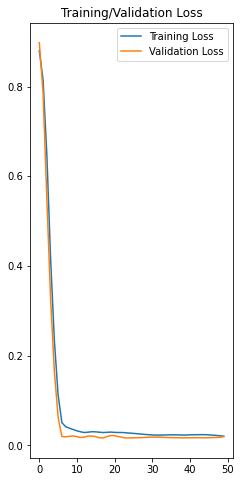

Epoch 1/50
95/95 [==============================] - 2s 5ms/step - loss: 0.0201 - mae: 0.0181 - rmse: 0.0200 - val_loss: 0.0232 - val_mae: 0.0212 - val_rmse: 0.0232
Epoch 2/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0235 - mae: 0.0215 - rmse: 0.0234 - val_loss: 0.0226 - val_mae: 0.0205 - val_rmse: 0.0226
Epoch 3/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0230 - mae: 0.0211 - rmse: 0.0229 - val_loss: 0.0214 - val_mae: 0.0192 - val_rmse: 0.0214
Epoch 4/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0223 - mae: 0.0205 - rmse: 0.0222 - val_loss: 0.0201 - val_mae: 0.0180 - val_rmse: 0.0201
Epoch 5/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0217 - mae: 0.0200 - rmse: 0.0216 - val_loss: 0.0192 - val_mae: 0.0173 - val_rmse: 0.0192
Epoch 6/50
95/95 [==============================] - 0s 5ms/step - loss: 0.0214 - mae: 0.0198 - rmse: 0.0213 - val_loss: 0.0181 - val_mae: 0.0164 - val_rmse: 0.0181
Epoch 7/50
95/95

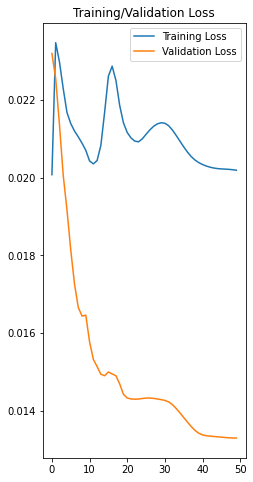

Epoch 1/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0371 - mae: 0.0346 - rmse: 0.0374 - val_loss: 0.1227 - val_mae: 0.1146 - val_rmse: 0.1250
Epoch 2/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0443 - mae: 0.0418 - rmse: 0.0443 - val_loss: 0.1047 - val_mae: 0.0979 - val_rmse: 0.1067
Epoch 3/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0312 - mae: 0.0289 - rmse: 0.0313 - val_loss: 0.1001 - val_mae: 0.0937 - val_rmse: 0.1019
Epoch 4/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0281 - mae: 0.0258 - rmse: 0.0281 - val_loss: 0.0973 - val_mae: 0.0911 - val_rmse: 0.0990
Epoch 5/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0274 - mae: 0.0252 - rmse: 0.0275 - val_loss: 0.0944 - val_mae: 0.0884 - val_rmse: 0.0961
Epoch 6/50
142/142 [==============================] - 1s 5ms/step - loss: 0.0269 - mae: 0.0247 - rmse: 0.0270 - val_loss: 0.0915 - val_mae: 0.0856 - val_rmse: 0.0931
Epoc

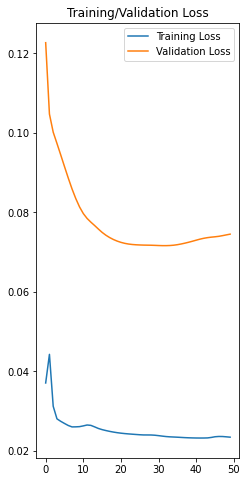

[array([[69.54906 , 70.60791 , 69.27195 , 67.06643 , 68.82572 , 71.37457 ,
        68.51459 , 68.07292 , 71.4185  , 71.748055, 67.54429 , 69.71756 ,
        70.254845, 70.9961  , 68.066376, 68.13181 , 68.53815 , 69.780304,
        68.27452 , 72.96621 , 68.14144 , 66.10995 , 67.89325 , 71.087494,
        71.26196 , 68.51009 , 69.129486, 67.3123  , 67.77133 , 71.639626,
        73.85341 , 69.920364, 68.06634 , 70.5673  , 64.25087 , 65.15563 ,
        68.67056 , 66.07826 , 72.654045, 68.34499 , 68.05532 , 69.45175 ,
        69.70694 , 70.08098 , 65.371796, 69.81244 , 68.37825 , 69.59117 ,
        68.51493 , 70.24383 , 68.13752 , 70.997665, 67.694595, 69.444534,
        68.80726 , 69.86094 , 67.86109 , 64.44794 , 67.68953 , 69.084404,
        70.025345, 72.20337 , 70.22193 , 72.14748 , 68.771545, 69.353905,
        69.39561 , 69.39664 , 66.5315  , 71.54957 , 67.28757 , 70.32631 ,
        70.90856 , 69.00522 , 70.285286, 68.65663 , 69.61467 ]],
      dtype=float32)]
Previsões:
[69.54906]


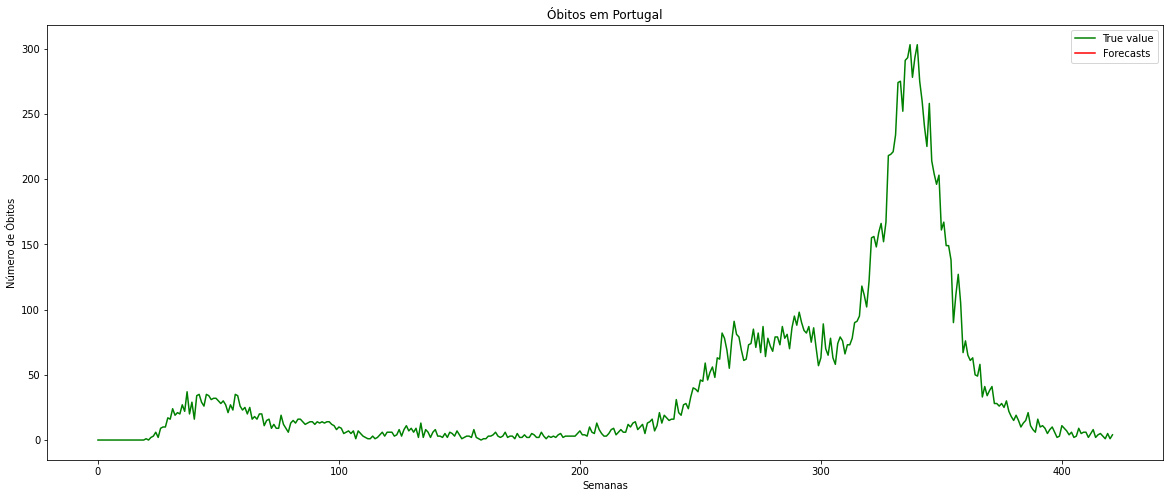

Epoch 1/100
32/32 [==============================] - 4s 28ms/step - loss: 0.9027 - mae: 0.9024 - rmse: 0.9030 - val_loss: 0.9435 - val_mae: 0.9434 - val_rmse: 0.9476
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.9012 - mae: 0.9009 - rmse: 0.9015 - val_loss: 0.9419 - val_mae: 0.9418 - val_rmse: 0.9460
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.8997 - mae: 0.8993 - rmse: 0.8999 - val_loss: 0.9403 - val_mae: 0.9402 - val_rmse: 0.9444
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.8981 - mae: 0.8977 - rmse: 0.8983 - val_loss: 0.9386 - val_mae: 0.9384 - val_rmse: 0.9427
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.8964 - mae: 0.8960 - rmse: 0.8966 - val_loss: 0.9368 - val_mae: 0.9366 - val_rmse: 0.9408
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.8945 - mae: 0.8941 - rmse: 0.8948 - val_loss: 0.9348 - val_mae: 0.9346 - val_rmse: 0.9389
Epoch 7/1

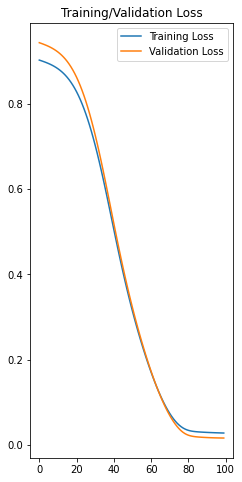

Epoch 1/100
63/63 [==============================] - 2s 5ms/step - loss: 0.0288 - mae: 0.0262 - rmse: 0.0288 - val_loss: 0.0335 - val_mae: 0.0313 - val_rmse: 0.0343
Epoch 2/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0278 - mae: 0.0249 - rmse: 0.0278 - val_loss: 0.0293 - val_mae: 0.0271 - val_rmse: 0.0300
Epoch 3/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0279 - mae: 0.0250 - rmse: 0.0279 - val_loss: 0.0287 - val_mae: 0.0266 - val_rmse: 0.0295
Epoch 4/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0277 - mae: 0.0248 - rmse: 0.0277 - val_loss: 0.0284 - val_mae: 0.0263 - val_rmse: 0.0292
Epoch 5/100
63/63 [==============================] - 0s 4ms/step - loss: 0.0274 - mae: 0.0246 - rmse: 0.0274 - val_loss: 0.0282 - val_mae: 0.0260 - val_rmse: 0.0289
Epoch 6/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0272 - mae: 0.0244 - rmse: 0.0272 - val_loss: 0.0279 - val_mae: 0.0257 - val_rmse: 0.0287
Epoch 7/10

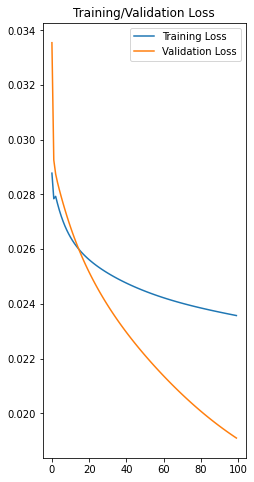

Epoch 1/100
95/95 [==============================] - 0s 5ms/step - loss: 0.0541 - mae: 0.0497 - rmse: 0.0559 - val_loss: 0.2263 - val_mae: 0.2117 - val_rmse: 0.2311
Epoch 2/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0542 - mae: 0.0496 - rmse: 0.0559 - val_loss: 0.2182 - val_mae: 0.2028 - val_rmse: 0.2233
Epoch 3/100
95/95 [==============================] - 0s 5ms/step - loss: 0.0525 - mae: 0.0478 - rmse: 0.0542 - val_loss: 0.2114 - val_mae: 0.1954 - val_rmse: 0.2167
Epoch 4/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0509 - mae: 0.0462 - rmse: 0.0525 - val_loss: 0.2053 - val_mae: 0.1887 - val_rmse: 0.2107
Epoch 5/100
95/95 [==============================] - 0s 4ms/step - loss: 0.0495 - mae: 0.0448 - rmse: 0.0510 - val_loss: 0.1996 - val_mae: 0.1827 - val_rmse: 0.2052
Epoch 6/100
95/95 [==============================] - 0s 5ms/step - loss: 0.0481 - mae: 0.0435 - rmse: 0.0496 - val_loss: 0.1944 - val_mae: 0.1771 - val_rmse: 0.2000
Epoch 7/10

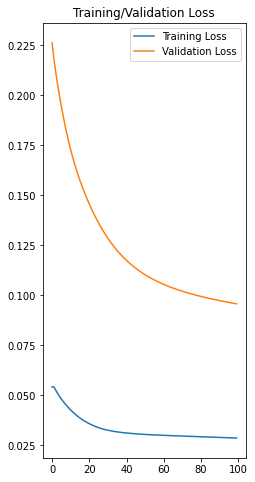

[array([[73.89169 , 73.93822 , 74.70092 , 74.43566 , 76.2541  , 72.11103 ,
        78.84829 , 72.499626, 70.2665  , 74.27047 , 70.30172 , 73.757805,
        68.71484 , 74.79978 , 75.19992 , 74.94394 , 72.76535 , 70.58432 ,
        73.63462 , 77.26424 , 77.27047 , 74.582695, 74.424164, 71.10314 ,
        72.40079 , 78.4999  , 70.90124 , 73.48246 , 73.671875, 76.09224 ,
        71.106224, 69.82461 , 73.21441 , 73.49077 , 71.45294 , 73.71818 ,
        75.58381 , 76.071075, 74.60531 , 76.733055, 69.14818 , 70.94488 ,
        70.637085, 73.3751  , 75.24369 , 69.72486 , 73.88718 , 77.53431 ,
        74.536446, 67.45607 , 70.040115, 70.5268  , 72.26222 , 72.61484 ,
        71.263466, 71.75878 , 75.675156, 76.94634 , 77.24228 , 71.41728 ,
        72.65294 , 71.18663 , 71.34493 , 76.45984 , 71.521065, 74.442955,
        78.20111 , 68.635925, 76.64932 , 74.18808 , 72.878555, 76.79186 ,
        70.87905 , 73.255226, 72.661064, 68.5421  , 70.76488 ]],
      dtype=float32)]
Previsões:
[73.89169]


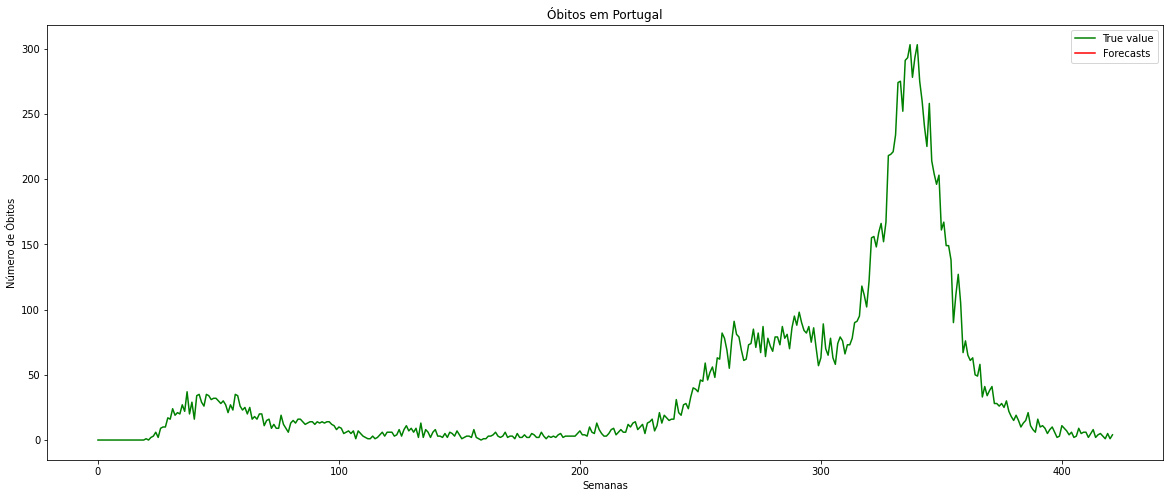

Epoch 1/60
96/96 [==============================] - 4s 12ms/step - loss: 0.2439 - mae: 0.2268 - rmse: 0.2439 - val_loss: 0.0682 - val_mae: 0.0669 - val_rmse: 0.0682
Epoch 2/60
96/96 [==============================] - 0s 4ms/step - loss: 0.0310 - mae: 0.0289 - rmse: 0.0310 - val_loss: 0.0633 - val_mae: 0.0624 - val_rmse: 0.0633
Epoch 3/60
96/96 [==============================] - 0s 4ms/step - loss: 0.0311 - mae: 0.0292 - rmse: 0.0311 - val_loss: 0.0584 - val_mae: 0.0570 - val_rmse: 0.0584
Epoch 4/60
96/96 [==============================] - 0s 4ms/step - loss: 0.0305 - mae: 0.0283 - rmse: 0.0305 - val_loss: 0.0605 - val_mae: 0.0599 - val_rmse: 0.0605
Epoch 5/60
96/96 [==============================] - 0s 4ms/step - loss: 0.0311 - mae: 0.0290 - rmse: 0.0311 - val_loss: 0.0601 - val_mae: 0.0594 - val_rmse: 0.0601
Epoch 6/60
96/96 [==============================] - 0s 4ms/step - loss: 0.0307 - mae: 0.0286 - rmse: 0.0307 - val_loss: 0.0591 - val_mae: 0.0581 - val_rmse: 0.0591
Epoch 7/60
96/9

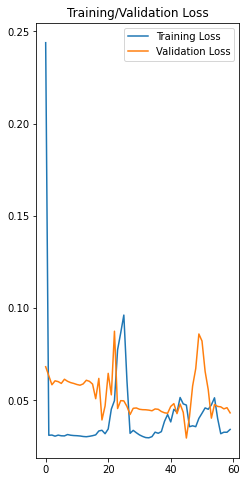

Epoch 1/60
189/189 [==============================] - 1s 4ms/step - loss: 0.0300 - mae: 0.0275 - rmse: 0.0300 - val_loss: 0.0176 - val_mae: 0.0169 - val_rmse: 0.0176
Epoch 2/60
189/189 [==============================] - 1s 4ms/step - loss: 0.0248 - mae: 0.0227 - rmse: 0.0248 - val_loss: 0.0163 - val_mae: 0.0158 - val_rmse: 0.0163
Epoch 3/60
189/189 [==============================] - 1s 4ms/step - loss: 0.0249 - mae: 0.0230 - rmse: 0.0249 - val_loss: 0.0194 - val_mae: 0.0186 - val_rmse: 0.0194
Epoch 4/60
189/189 [==============================] - 1s 4ms/step - loss: 0.0264 - mae: 0.0243 - rmse: 0.0264 - val_loss: 0.0181 - val_mae: 0.0174 - val_rmse: 0.0181
Epoch 5/60
189/189 [==============================] - 1s 5ms/step - loss: 0.0220 - mae: 0.0202 - rmse: 0.0220 - val_loss: 0.0166 - val_mae: 0.0160 - val_rmse: 0.0166
Epoch 6/60
189/189 [==============================] - 1s 4ms/step - loss: 0.0203 - mae: 0.0187 - rmse: 0.0203 - val_loss: 0.0174 - val_mae: 0.0171 - val_rmse: 0.0174
Epoc

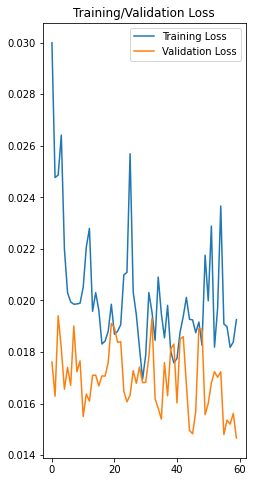

Epoch 1/60
283/283 [==============================] - 1s 4ms/step - loss: 0.0263 - mae: 0.0257 - rmse: 0.0263 - val_loss: 0.1237 - val_mae: 0.1232 - val_rmse: 0.1237
Epoch 2/60
283/283 [==============================] - 1s 4ms/step - loss: 0.0383 - mae: 0.0375 - rmse: 0.0383 - val_loss: 0.1075 - val_mae: 0.1066 - val_rmse: 0.1075
Epoch 3/60
283/283 [==============================] - 1s 4ms/step - loss: 0.0345 - mae: 0.0338 - rmse: 0.0345 - val_loss: 0.0798 - val_mae: 0.0791 - val_rmse: 0.0798
Epoch 4/60
283/283 [==============================] - 1s 4ms/step - loss: 0.0330 - mae: 0.0324 - rmse: 0.0330 - val_loss: 0.0991 - val_mae: 0.0984 - val_rmse: 0.0991
Epoch 5/60
283/283 [==============================] - 1s 4ms/step - loss: 0.0255 - mae: 0.0249 - rmse: 0.0255 - val_loss: 0.1011 - val_mae: 0.1007 - val_rmse: 0.1011
Epoch 6/60
283/283 [==============================] - 1s 4ms/step - loss: 0.0253 - mae: 0.0248 - rmse: 0.0253 - val_loss: 0.1153 - val_mae: 0.1149 - val_rmse: 0.1153
Epoc

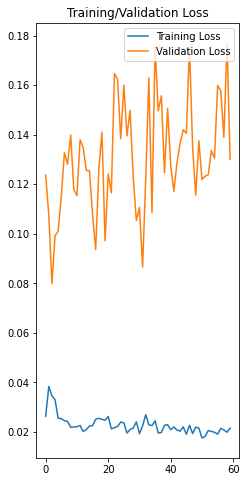

[array([[40.449085, 40.90922 , 39.754265, 40.15779 , 40.107903, 39.875076,
        40.20592 , 40.279896, 39.69854 , 38.8711  , 38.6366  , 39.192493,
        39.160915, 40.01333 , 39.817078, 39.00185 , 40.34922 , 39.838604,
        38.11473 , 40.27662 , 39.74294 , 39.24698 , 40.475697, 39.719162,
        38.050655, 39.691315, 38.785595, 38.45596 , 39.903965, 39.199318,
        39.242626, 39.539665, 38.36343 , 39.796173, 39.790646, 40.126583,
        39.834236, 39.23219 , 40.12013 , 37.680058, 38.48895 , 38.866425,
        38.223236, 39.17093 , 38.8968  , 40.397892, 37.32866 , 39.960865,
        40.189667, 38.964336, 39.413857, 38.503765, 39.797733, 39.07177 ,
        39.889076, 38.781868, 38.084995, 39.573345, 39.38675 , 39.819984,
        38.083252, 39.819794, 39.85026 , 39.357853, 39.098625, 40.313343,
        38.426197, 39.97699 , 39.725826, 40.092667, 38.549583, 38.600216,
        39.418514, 38.990517, 38.96347 , 39.91063 , 39.537098]],
      dtype=float32)]
Previsões:
[40.449085]


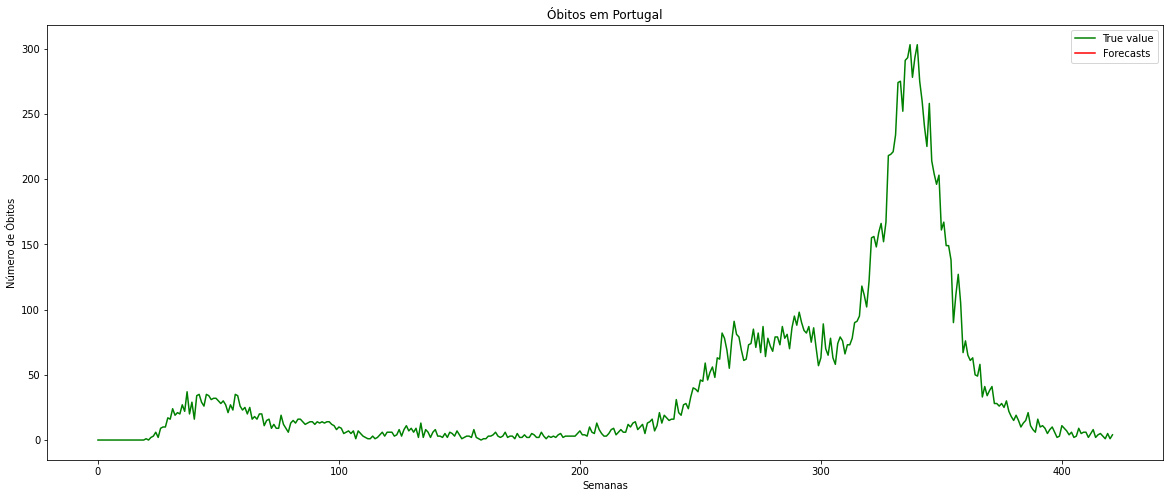

Epoch 1/90
48/48 [==============================] - 3s 20ms/step - loss: 0.8793 - mae: 0.8767 - rmse: 0.8793 - val_loss: 0.9053 - val_mae: 0.9001 - val_rmse: 0.9053
Epoch 2/90
48/48 [==============================] - 0s 6ms/step - loss: 0.7919 - mae: 0.7763 - rmse: 0.7919 - val_loss: 0.7486 - val_mae: 0.7113 - val_rmse: 0.7486
Epoch 3/90
48/48 [==============================] - 0s 5ms/step - loss: 0.5673 - mae: 0.4912 - rmse: 0.5673 - val_loss: 0.4582 - val_mae: 0.3571 - val_rmse: 0.4582
Epoch 4/90
48/48 [==============================] - 0s 5ms/step - loss: 0.3114 - mae: 0.2305 - rmse: 0.3114 - val_loss: 0.2154 - val_mae: 0.1400 - val_rmse: 0.2154
Epoch 5/90
48/48 [==============================] - 0s 5ms/step - loss: 0.1257 - mae: 0.0903 - rmse: 0.1257 - val_loss: 0.0535 - val_mae: 0.0341 - val_rmse: 0.0535
Epoch 6/90
48/48 [==============================] - 0s 5ms/step - loss: 0.0607 - mae: 0.0531 - rmse: 0.0607 - val_loss: 0.0282 - val_mae: 0.0245 - val_rmse: 0.0282
Epoch 7/90
48/4

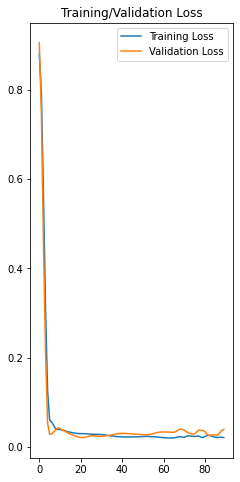

Epoch 1/90
95/95 [==============================] - 2s 7ms/step - loss: 0.0211 - mae: 0.0184 - rmse: 0.0210 - val_loss: 0.0273 - val_mae: 0.0250 - val_rmse: 0.0285
Epoch 2/90
95/95 [==============================] - 1s 6ms/step - loss: 0.0286 - mae: 0.0262 - rmse: 0.0285 - val_loss: 0.0215 - val_mae: 0.0198 - val_rmse: 0.0226
Epoch 3/90
95/95 [==============================] - 1s 6ms/step - loss: 0.0272 - mae: 0.0249 - rmse: 0.0271 - val_loss: 0.0211 - val_mae: 0.0195 - val_rmse: 0.0221
Epoch 4/90
95/95 [==============================] - 1s 7ms/step - loss: 0.0271 - mae: 0.0248 - rmse: 0.0270 - val_loss: 0.0194 - val_mae: 0.0179 - val_rmse: 0.0202
Epoch 5/90
95/95 [==============================] - 1s 7ms/step - loss: 0.0265 - mae: 0.0241 - rmse: 0.0264 - val_loss: 0.0185 - val_mae: 0.0172 - val_rmse: 0.0193
Epoch 6/90
95/95 [==============================] - 1s 7ms/step - loss: 0.0267 - mae: 0.0241 - rmse: 0.0266 - val_loss: 0.0181 - val_mae: 0.0168 - val_rmse: 0.0188
Epoch 7/90
95/95

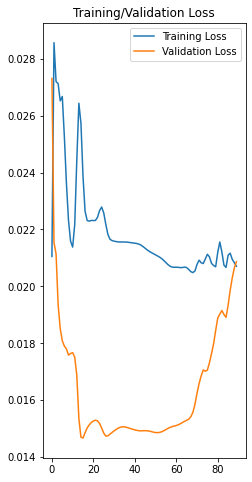

Epoch 1/90
142/142 [==============================] - 1s 7ms/step - loss: 0.0382 - mae: 0.0349 - rmse: 0.0387 - val_loss: 0.1803 - val_mae: 0.1729 - val_rmse: 0.1830
Epoch 2/90
142/142 [==============================] - 1s 6ms/step - loss: 0.0395 - mae: 0.0360 - rmse: 0.0395 - val_loss: 0.1560 - val_mae: 0.1483 - val_rmse: 0.1599
Epoch 3/90
142/142 [==============================] - 1s 6ms/step - loss: 0.0308 - mae: 0.0274 - rmse: 0.0309 - val_loss: 0.1419 - val_mae: 0.1333 - val_rmse: 0.1461
Epoch 4/90
142/142 [==============================] - 1s 6ms/step - loss: 0.0299 - mae: 0.0265 - rmse: 0.0299 - val_loss: 0.1342 - val_mae: 0.1255 - val_rmse: 0.1384
Epoch 5/90
142/142 [==============================] - 1s 6ms/step - loss: 0.0278 - mae: 0.0245 - rmse: 0.0278 - val_loss: 0.1266 - val_mae: 0.1175 - val_rmse: 0.1308
Epoch 6/90
142/142 [==============================] - 1s 6ms/step - loss: 0.0266 - mae: 0.0234 - rmse: 0.0266 - val_loss: 0.1199 - val_mae: 0.1110 - val_rmse: 0.1240
Epoc

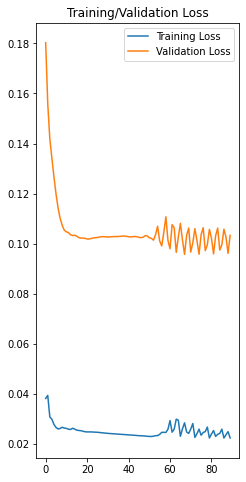

[array([[51.457153, 56.09159 , 52.17539 , 48.722717, 47.25409 , 51.80872 ,
        51.969376, 51.552773, 49.145824, 50.006256, 51.331814, 51.468277,
        50.211403, 52.557327, 55.25359 , 49.744476, 51.442062, 55.149887,
        49.093124, 52.04558 , 54.978855, 52.3252  , 50.82238 , 53.843456,
        49.696545, 50.891895, 55.851734, 51.665348, 52.51476 , 49.88615 ,
        52.300114, 54.554558, 50.860218, 53.490486, 49.719517, 45.57403 ,
        54.771957, 52.38885 , 52.065845, 52.205433, 54.469578, 54.00688 ,
        47.926147, 53.851448, 53.22987 , 52.305954, 52.86518 , 51.413475,
        47.978207, 52.669334, 48.538704, 54.962784, 55.730396, 51.75154 ,
        51.069454, 54.277065, 56.068066, 45.541187, 54.965374, 53.406986,
        50.702423, 52.144928, 55.47357 , 46.078976, 50.871586, 58.19239 ,
        50.96316 , 50.024616, 49.92709 , 52.46686 , 49.427628, 52.98469 ,
        52.254402, 53.035362, 49.428844, 50.146072, 54.724857]],
      dtype=float32)]
Previsões:
[51.457153]


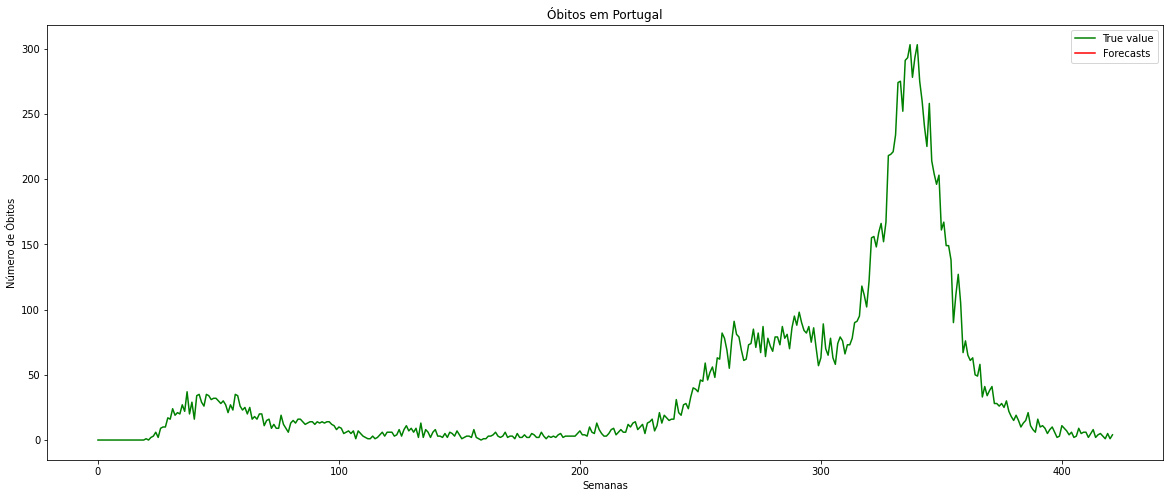

Epoch 1/120
32/32 [==============================] - 3s 28ms/step - loss: 0.9140 - mae: 0.9129 - rmse: 0.9140 - val_loss: 0.9694 - val_mae: 0.9685 - val_rmse: 0.9689
Epoch 2/120
32/32 [==============================] - 0s 5ms/step - loss: 0.9106 - mae: 0.9096 - rmse: 0.9106 - val_loss: 0.9659 - val_mae: 0.9651 - val_rmse: 0.9654
Epoch 3/120
32/32 [==============================] - 0s 6ms/step - loss: 0.9074 - mae: 0.9065 - rmse: 0.9074 - val_loss: 0.9626 - val_mae: 0.9619 - val_rmse: 0.9620
Epoch 4/120
32/32 [==============================] - 0s 5ms/step - loss: 0.9043 - mae: 0.9034 - rmse: 0.9043 - val_loss: 0.9594 - val_mae: 0.9587 - val_rmse: 0.9588
Epoch 5/120
32/32 [==============================] - 0s 6ms/step - loss: 0.9012 - mae: 0.9004 - rmse: 0.9012 - val_loss: 0.9561 - val_mae: 0.9554 - val_rmse: 0.9555
Epoch 6/120
32/32 [==============================] - 0s 5ms/step - loss: 0.8981 - mae: 0.8973 - rmse: 0.8981 - val_loss: 0.9528 - val_mae: 0.9521 - val_rmse: 0.9522
Epoch 7/1

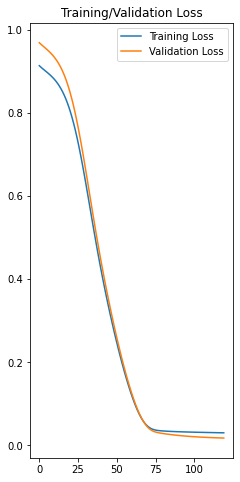

Epoch 1/120
63/63 [==============================] - 1s 17ms/step - loss: 0.0293 - mae: 0.0266 - rmse: 0.0293 - val_loss: 0.0302 - val_mae: 0.0282 - val_rmse: 0.0302
Epoch 2/120
63/63 [==============================] - 0s 5ms/step - loss: 0.0280 - mae: 0.0252 - rmse: 0.0280 - val_loss: 0.0249 - val_mae: 0.0231 - val_rmse: 0.0249
Epoch 3/120
63/63 [==============================] - 0s 5ms/step - loss: 0.0277 - mae: 0.0250 - rmse: 0.0277 - val_loss: 0.0239 - val_mae: 0.0220 - val_rmse: 0.0239
Epoch 4/120
63/63 [==============================] - 0s 5ms/step - loss: 0.0273 - mae: 0.0246 - rmse: 0.0273 - val_loss: 0.0234 - val_mae: 0.0215 - val_rmse: 0.0234
Epoch 5/120
63/63 [==============================] - 0s 5ms/step - loss: 0.0269 - mae: 0.0243 - rmse: 0.0269 - val_loss: 0.0231 - val_mae: 0.0212 - val_rmse: 0.0231
Epoch 6/120
63/63 [==============================] - 0s 5ms/step - loss: 0.0266 - mae: 0.0241 - rmse: 0.0266 - val_loss: 0.0228 - val_mae: 0.0208 - val_rmse: 0.0228
Epoch 7/1

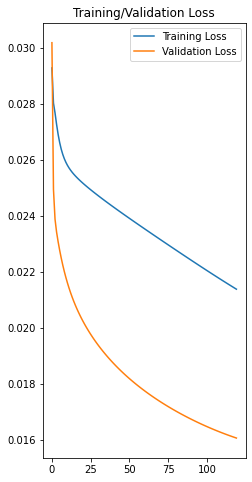

Epoch 1/120
95/95 [==============================] - 2s 7ms/step - loss: 0.0415 - mae: 0.0372 - rmse: 0.0421 - val_loss: 0.1983 - val_mae: 0.1786 - val_rmse: 0.2072
Epoch 2/120
95/95 [==============================] - 1s 7ms/step - loss: 0.0401 - mae: 0.0360 - rmse: 0.0405 - val_loss: 0.1871 - val_mae: 0.1670 - val_rmse: 0.1963
Epoch 3/120
95/95 [==============================] - 1s 7ms/step - loss: 0.0380 - mae: 0.0340 - rmse: 0.0383 - val_loss: 0.1787 - val_mae: 0.1581 - val_rmse: 0.1882
Epoch 4/120
95/95 [==============================] - 1s 7ms/step - loss: 0.0365 - mae: 0.0325 - rmse: 0.0367 - val_loss: 0.1722 - val_mae: 0.1510 - val_rmse: 0.1818
Epoch 5/120
95/95 [==============================] - 1s 6ms/step - loss: 0.0353 - mae: 0.0313 - rmse: 0.0355 - val_loss: 0.1668 - val_mae: 0.1451 - val_rmse: 0.1766
Epoch 6/120
95/95 [==============================] - 1s 7ms/step - loss: 0.0344 - mae: 0.0303 - rmse: 0.0345 - val_loss: 0.1624 - val_mae: 0.1402 - val_rmse: 0.1722
Epoch 7/12

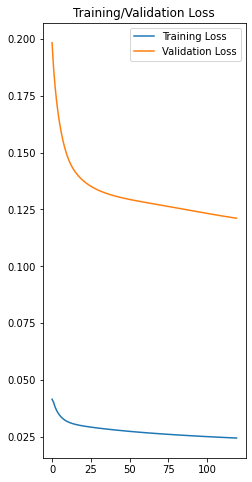

[array([[ 95.85029 ,  97.91927 , 105.07553 ,  99.2708  ,  97.317924,
        107.748695,  87.57796 ,  97.526146,  82.40965 ,  89.130104,
         98.51485 ,  91.15943 ,  95.53064 , 101.44907 ,  96.72859 ,
         86.317604, 100.022575,  99.71097 ,  77.97842 ,  92.85072 ,
        100.41271 ,  91.74932 ,  93.41193 ,  94.41322 ,  93.43298 ,
        100.575134, 101.03881 ,  95.23754 ,  96.63455 ,  88.51449 ,
         86.17668 , 102.23238 ,  96.40806 ,  90.086914,  98.25246 ,
        104.35192 ,  87.65495 ,  93.34283 ,  94.29829 ,  97.17585 ,
        102.084656,  99.6768  ,  90.44292 , 101.486725,  95.61957 ,
        100.81002 ,  92.62831 , 104.55567 ,  96.35984 ,  96.77064 ,
         93.46432 ,  94.83608 ,  97.62631 ,  90.55431 ,  94.21853 ,
         96.53352 ,  90.59084 ,  83.3551  ,  95.16689 ,  96.876816,
        105.11731 ,  96.03669 , 104.21778 ,  89.15752 ,  96.64259 ,
         95.70209 ,  89.851265,  93.59051 ,  93.93211 , 100.735176,
         99.33226 ,  99.34687 ,  90.306725,  95

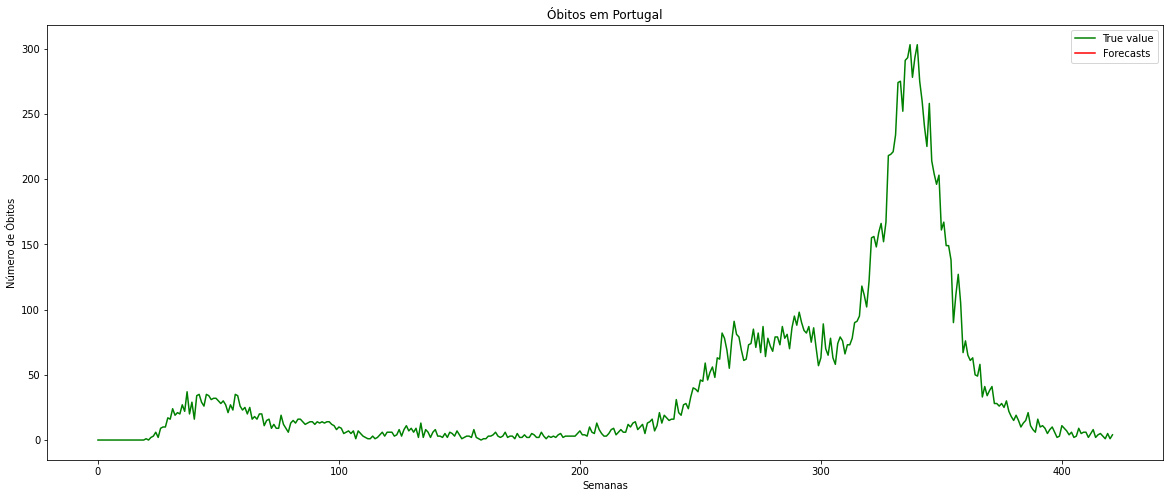

Epoch 1/50
94/94 [==============================] - 4s 14ms/step - loss: 0.2314 - mae: 0.2049 - rmse: 0.2314 - val_loss: 0.0426 - val_mae: 0.0410 - val_rmse: 0.0426
Epoch 2/50
94/94 [==============================] - 1s 6ms/step - loss: 0.0291 - mae: 0.0266 - rmse: 0.0291 - val_loss: 0.0527 - val_mae: 0.0512 - val_rmse: 0.0527
Epoch 3/50
94/94 [==============================] - 1s 6ms/step - loss: 0.0312 - mae: 0.0287 - rmse: 0.0312 - val_loss: 0.0632 - val_mae: 0.0605 - val_rmse: 0.0632
Epoch 4/50
94/94 [==============================] - 1s 5ms/step - loss: 0.0336 - mae: 0.0311 - rmse: 0.0336 - val_loss: 0.0551 - val_mae: 0.0525 - val_rmse: 0.0551
Epoch 5/50
94/94 [==============================] - 1s 6ms/step - loss: 0.0324 - mae: 0.0301 - rmse: 0.0324 - val_loss: 0.0528 - val_mae: 0.0501 - val_rmse: 0.0528
Epoch 6/50
94/94 [==============================] - 1s 6ms/step - loss: 0.0319 - mae: 0.0297 - rmse: 0.0319 - val_loss: 0.0516 - val_mae: 0.0490 - val_rmse: 0.0516
Epoch 7/50
94/9

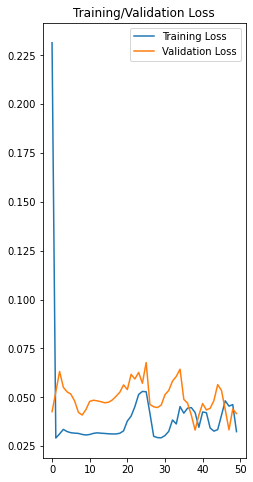

Epoch 1/50
188/188 [==============================] - 1s 6ms/step - loss: 0.0230 - mae: 0.0214 - rmse: 0.0230 - val_loss: 0.0174 - val_mae: 0.0167 - val_rmse: 0.0174
Epoch 2/50
188/188 [==============================] - 1s 6ms/step - loss: 0.0209 - mae: 0.0194 - rmse: 0.0209 - val_loss: 0.0172 - val_mae: 0.0166 - val_rmse: 0.0172
Epoch 3/50
188/188 [==============================] - 1s 6ms/step - loss: 0.0209 - mae: 0.0195 - rmse: 0.0209 - val_loss: 0.0169 - val_mae: 0.0163 - val_rmse: 0.0169
Epoch 4/50
188/188 [==============================] - 1s 6ms/step - loss: 0.0210 - mae: 0.0196 - rmse: 0.0210 - val_loss: 0.0166 - val_mae: 0.0160 - val_rmse: 0.0166
Epoch 5/50
188/188 [==============================] - 1s 6ms/step - loss: 0.0214 - mae: 0.0200 - rmse: 0.0214 - val_loss: 0.0164 - val_mae: 0.0159 - val_rmse: 0.0164
Epoch 6/50
188/188 [==============================] - 1s 6ms/step - loss: 0.0216 - mae: 0.0199 - rmse: 0.0216 - val_loss: 0.0167 - val_mae: 0.0162 - val_rmse: 0.0167
Epoc

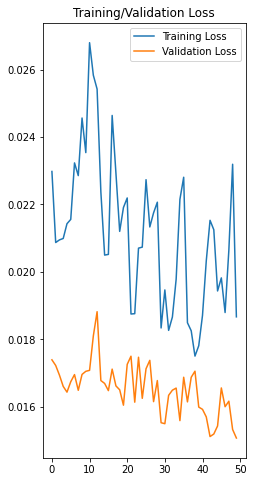

Epoch 1/50
281/281 [==============================] - 1s 5ms/step - loss: 0.0295 - mae: 0.0283 - rmse: 0.0295 - val_loss: 0.0749 - val_mae: 0.0740 - val_rmse: 0.0749
Epoch 2/50
281/281 [==============================] - 2s 5ms/step - loss: 0.0481 - mae: 0.0471 - rmse: 0.0481 - val_loss: 0.0787 - val_mae: 0.0784 - val_rmse: 0.0787
Epoch 3/50
281/281 [==============================] - 2s 6ms/step - loss: 0.0354 - mae: 0.0344 - rmse: 0.0354 - val_loss: 0.0802 - val_mae: 0.0799 - val_rmse: 0.0802
Epoch 4/50
281/281 [==============================] - 2s 5ms/step - loss: 0.0396 - mae: 0.0388 - rmse: 0.0396 - val_loss: 0.0709 - val_mae: 0.0702 - val_rmse: 0.0709
Epoch 5/50
281/281 [==============================] - 2s 6ms/step - loss: 0.0322 - mae: 0.0316 - rmse: 0.0322 - val_loss: 0.0726 - val_mae: 0.0721 - val_rmse: 0.0726
Epoch 6/50
281/281 [==============================] - 2s 5ms/step - loss: 0.0295 - mae: 0.0289 - rmse: 0.0295 - val_loss: 0.0874 - val_mae: 0.0871 - val_rmse: 0.0874
Epoc

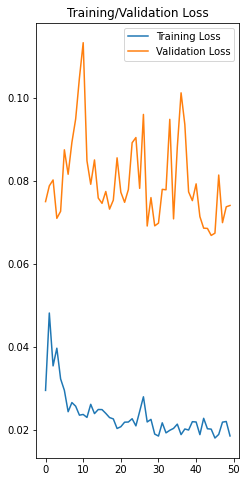

[array([[23.69938 , 22.780504, 23.470839, 22.492174, 25.897253, 22.507534,
        20.647188, 24.060116, 23.156057, 25.53447 , 24.73425 , 24.95193 ,
        20.885166, 22.575241, 21.071367, 24.593487, 22.220394, 21.307894,
        21.768997, 22.776035, 25.204256, 22.472488, 24.494562, 24.990856,
        22.320015, 21.582888, 22.882608, 23.802902, 23.527538, 21.262869,
        25.047142, 24.27057 , 23.772018, 24.436571, 25.446444, 24.050272,
        24.40148 , 23.551548, 23.971241, 22.51435 , 21.409843, 26.692173,
        26.582756, 24.714094, 24.407413, 25.571276, 24.72994 , 23.206797,
        25.118227, 27.22476 , 23.86233 , 22.033426, 22.235357, 24.56068 ,
        24.843197, 23.981445, 26.04477 , 23.005833, 22.896849, 23.570414,
        24.090258, 23.776625, 23.361809, 23.416025, 24.929714, 22.947462,
        25.471674, 24.473658, 21.921679, 22.264534, 23.797638, 22.482069,
        23.912771, 25.34705 , 25.077555, 26.685274, 22.696877]],
      dtype=float32)]
Previsões:
[23.69938]


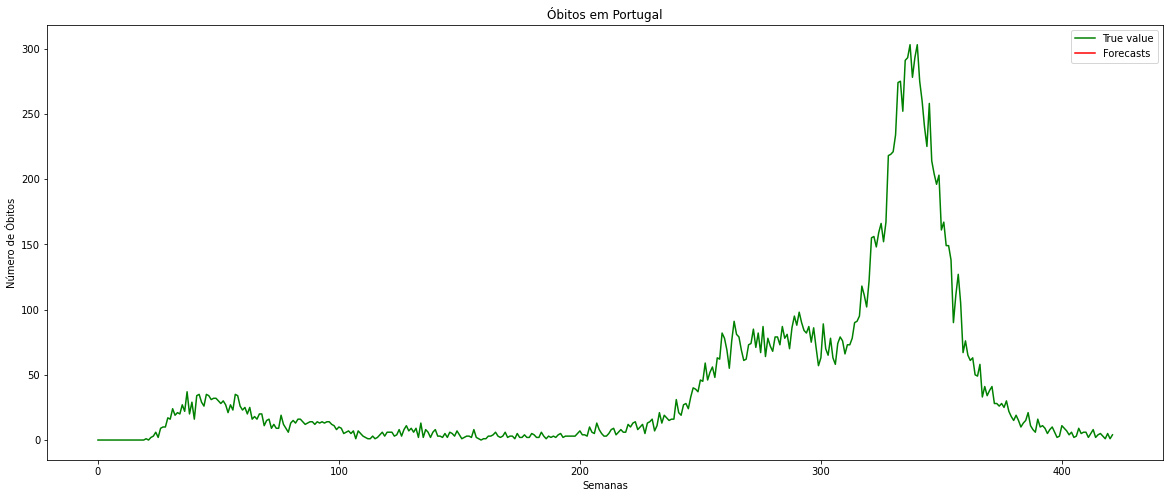

Epoch 1/90
47/47 [==============================] - 4s 24ms/step - loss: 0.8418 - mae: 0.8341 - rmse: 0.8418 - val_loss: 0.8178 - val_mae: 0.7986 - val_rmse: 0.8178
Epoch 2/90
47/47 [==============================] - 0s 7ms/step - loss: 0.6722 - mae: 0.6346 - rmse: 0.6722 - val_loss: 0.5880 - val_mae: 0.5267 - val_rmse: 0.5880
Epoch 3/90
47/47 [==============================] - 0s 7ms/step - loss: 0.4207 - mae: 0.3492 - rmse: 0.4207 - val_loss: 0.3191 - val_mae: 0.2464 - val_rmse: 0.3191
Epoch 4/90
47/47 [==============================] - 0s 7ms/step - loss: 0.1939 - mae: 0.1456 - rmse: 0.1939 - val_loss: 0.1066 - val_mae: 0.0705 - val_rmse: 0.1066
Epoch 5/90
47/47 [==============================] - 0s 7ms/step - loss: 0.0773 - mae: 0.0647 - rmse: 0.0773 - val_loss: 0.0360 - val_mae: 0.0320 - val_rmse: 0.0360
Epoch 6/90
47/47 [==============================] - 0s 8ms/step - loss: 0.0634 - mae: 0.0591 - rmse: 0.0634 - val_loss: 0.0350 - val_mae: 0.0322 - val_rmse: 0.0350
Epoch 7/90
47/4

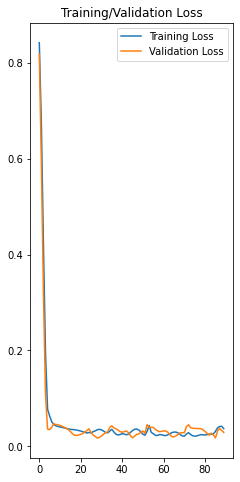

Epoch 1/90
94/94 [==============================] - 1s 7ms/step - loss: 0.0256 - mae: 0.0231 - rmse: 0.0256 - val_loss: 0.0159 - val_mae: 0.0142 - val_rmse: 0.0159
Epoch 2/90
94/94 [==============================] - 1s 6ms/step - loss: 0.0227 - mae: 0.0205 - rmse: 0.0227 - val_loss: 0.0146 - val_mae: 0.0129 - val_rmse: 0.0146
Epoch 3/90
94/94 [==============================] - 1s 6ms/step - loss: 0.0227 - mae: 0.0206 - rmse: 0.0227 - val_loss: 0.0147 - val_mae: 0.0129 - val_rmse: 0.0147
Epoch 4/90
94/94 [==============================] - 1s 7ms/step - loss: 0.0224 - mae: 0.0202 - rmse: 0.0224 - val_loss: 0.0149 - val_mae: 0.0131 - val_rmse: 0.0149
Epoch 5/90
94/94 [==============================] - 1s 6ms/step - loss: 0.0219 - mae: 0.0198 - rmse: 0.0219 - val_loss: 0.0150 - val_mae: 0.0132 - val_rmse: 0.0150
Epoch 6/90
94/94 [==============================] - 1s 7ms/step - loss: 0.0217 - mae: 0.0193 - rmse: 0.0217 - val_loss: 0.0150 - val_mae: 0.0132 - val_rmse: 0.0150
Epoch 7/90
94/94

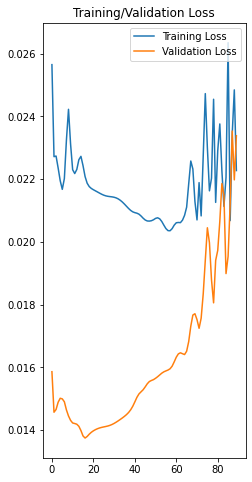

Epoch 1/90
141/141 [==============================] - 4s 13ms/step - loss: 0.0350 - mae: 0.0314 - rmse: 0.0353 - val_loss: 0.1498 - val_mae: 0.1391 - val_rmse: 0.1471
Epoch 2/90
141/141 [==============================] - 1s 9ms/step - loss: 0.0429 - mae: 0.0385 - rmse: 0.0430 - val_loss: 0.1501 - val_mae: 0.1392 - val_rmse: 0.1466
Epoch 3/90
141/141 [==============================] - 1s 9ms/step - loss: 0.0380 - mae: 0.0340 - rmse: 0.0381 - val_loss: 0.1053 - val_mae: 0.0950 - val_rmse: 0.1046
Epoch 4/90
141/141 [==============================] - 1s 9ms/step - loss: 0.0377 - mae: 0.0345 - rmse: 0.0377 - val_loss: 0.0927 - val_mae: 0.0837 - val_rmse: 0.0924
Epoch 5/90
141/141 [==============================] - 1s 9ms/step - loss: 0.0338 - mae: 0.0303 - rmse: 0.0338 - val_loss: 0.0999 - val_mae: 0.0907 - val_rmse: 0.0993
Epoch 6/90
141/141 [==============================] - 1s 9ms/step - loss: 0.0272 - mae: 0.0236 - rmse: 0.0272 - val_loss: 0.0952 - val_mae: 0.0863 - val_rmse: 0.0948
Epo

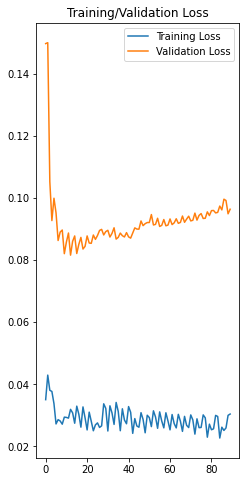

[array([[28.965052, 30.604746, 35.78959 , 31.374048, 26.275137, 24.778704,
        32.08029 , 33.743176, 33.786884, 24.41573 , 21.606464, 28.851849,
        23.130087, 32.342537, 29.377592, 25.498972, 26.12836 , 26.433361,
        26.627682, 30.32372 , 28.256369, 23.853876, 30.3442  , 24.494589,
        22.772043, 20.786106, 30.930634, 39.13928 , 18.403486, 36.01646 ,
        31.810184, 21.569956, 25.948103, 25.168722, 17.571507, 25.650036,
        27.760399, 24.175104, 28.30085 , 24.283655, 24.713894, 32.178513,
        23.281431, 29.985697, 28.694176, 26.439367, 20.34616 , 32.726433,
        17.976255, 23.253664, 23.717098, 32.87058 , 31.42607 , 34.883553,
        25.177446, 32.418198, 29.941973, 20.794685, 29.113081, 31.174175,
        25.675322, 33.8058  , 23.979729, 28.852898, 24.654594, 29.55785 ,
        21.83377 , 26.21589 , 24.531975, 34.241024, 34.688972, 29.844357,
        29.532665, 37.801304, 30.438429, 22.25907 , 27.631584]],
      dtype=float32)]
Previsões:
[28.965052]


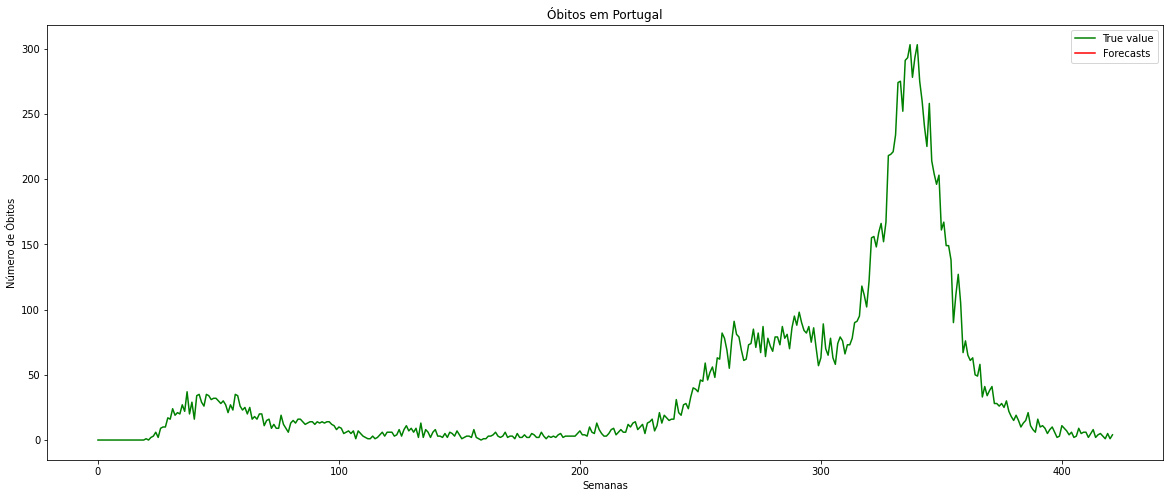

Epoch 1/120
32/32 [==============================] - 4s 32ms/step - loss: 0.9048 - mae: 0.9001 - rmse: 0.9052 - val_loss: 0.9566 - val_mae: 0.9524 - val_rmse: 0.9561
Epoch 2/120
32/32 [==============================] - 0s 9ms/step - loss: 0.8983 - mae: 0.8936 - rmse: 0.8986 - val_loss: 0.9499 - val_mae: 0.9456 - val_rmse: 0.9493
Epoch 3/120
32/32 [==============================] - 0s 10ms/step - loss: 0.8918 - mae: 0.8870 - rmse: 0.8921 - val_loss: 0.9431 - val_mae: 0.9386 - val_rmse: 0.9425
Epoch 4/120
32/32 [==============================] - 0s 9ms/step - loss: 0.8852 - mae: 0.8801 - rmse: 0.8855 - val_loss: 0.9361 - val_mae: 0.9312 - val_rmse: 0.9356
Epoch 5/120
32/32 [==============================] - 0s 10ms/step - loss: 0.8783 - mae: 0.8729 - rmse: 0.8787 - val_loss: 0.9289 - val_mae: 0.9234 - val_rmse: 0.9283
Epoch 6/120
32/32 [==============================] - 0s 9ms/step - loss: 0.8712 - mae: 0.8651 - rmse: 0.8715 - val_loss: 0.9211 - val_mae: 0.9149 - val_rmse: 0.9206
Epoch 7

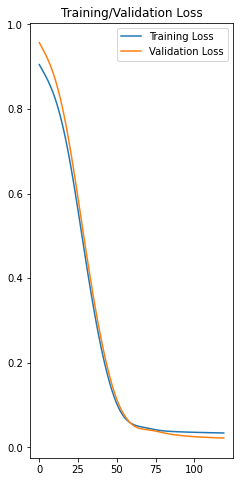

Epoch 1/120
63/63 [==============================] - 1s 9ms/step - loss: 0.0326 - mae: 0.0294 - rmse: 0.0326 - val_loss: 0.0252 - val_mae: 0.0235 - val_rmse: 0.0255
Epoch 2/120
63/63 [==============================] - 1s 8ms/step - loss: 0.0303 - mae: 0.0274 - rmse: 0.0302 - val_loss: 0.0195 - val_mae: 0.0177 - val_rmse: 0.0197
Epoch 3/120
63/63 [==============================] - 1s 8ms/step - loss: 0.0294 - mae: 0.0266 - rmse: 0.0293 - val_loss: 0.0180 - val_mae: 0.0160 - val_rmse: 0.0182
Epoch 4/120
63/63 [==============================] - 1s 9ms/step - loss: 0.0286 - mae: 0.0258 - rmse: 0.0285 - val_loss: 0.0174 - val_mae: 0.0153 - val_rmse: 0.0175
Epoch 5/120
63/63 [==============================] - 1s 8ms/step - loss: 0.0280 - mae: 0.0252 - rmse: 0.0279 - val_loss: 0.0170 - val_mae: 0.0147 - val_rmse: 0.0171
Epoch 6/120
63/63 [==============================] - 1s 8ms/step - loss: 0.0277 - mae: 0.0249 - rmse: 0.0276 - val_loss: 0.0167 - val_mae: 0.0143 - val_rmse: 0.0168
Epoch 7/12

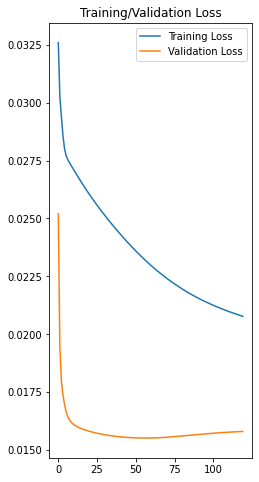

Epoch 1/120
94/94 [==============================] - 1s 9ms/step - loss: 0.0397 - mae: 0.0341 - rmse: 0.0404 - val_loss: 0.2373 - val_mae: 0.2163 - val_rmse: 0.2382
Epoch 2/120
94/94 [==============================] - 1s 8ms/step - loss: 0.0362 - mae: 0.0309 - rmse: 0.0368 - val_loss: 0.2160 - val_mae: 0.1950 - val_rmse: 0.2175
Epoch 3/120
94/94 [==============================] - 1s 9ms/step - loss: 0.0341 - mae: 0.0289 - rmse: 0.0347 - val_loss: 0.2017 - val_mae: 0.1810 - val_rmse: 0.2034
Epoch 4/120
94/94 [==============================] - 1s 8ms/step - loss: 0.0329 - mae: 0.0278 - rmse: 0.0335 - val_loss: 0.1914 - val_mae: 0.1711 - val_rmse: 0.1933
Epoch 5/120
94/94 [==============================] - 1s 9ms/step - loss: 0.0322 - mae: 0.0272 - rmse: 0.0327 - val_loss: 0.1838 - val_mae: 0.1641 - val_rmse: 0.1859
Epoch 6/120
94/94 [==============================] - 1s 9ms/step - loss: 0.0318 - mae: 0.0268 - rmse: 0.0322 - val_loss: 0.1780 - val_mae: 0.1588 - val_rmse: 0.1802
Epoch 7/12

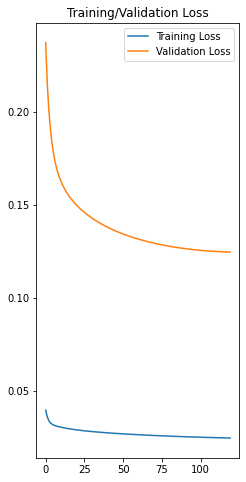

[array([[ 83.80256 , 104.336945, 121.33595 , 102.74615 , 106.34899 ,
         92.52841 ,  94.60726 , 109.95495 ,  92.89721 , 108.69492 ,
        100.16879 , 120.48126 ,  76.957924,  98.04526 ,  98.46484 ,
         73.51656 ,  85.8508  ,  72.953   , 104.41686 ,  88.65862 ,
        113.969826, 106.00135 ,  95.653305,  97.68235 , 103.438034,
        116.48381 , 109.14428 ,  80.86013 , 101.77635 , 112.67814 ,
        100.63993 ,  98.55679 , 121.463165, 118.50382 , 118.98556 ,
        116.75815 , 111.51931 ,  93.41135 , 107.32975 ,  79.54165 ,
         97.64957 , 106.87832 ,  74.105865,  99.62588 ,  90.39894 ,
        121.57919 , 120.54324 ,  86.919   , 102.20053 ,  83.97363 ,
         89.91364 , 107.18675 , 117.39556 , 104.47389 ,  87.095184,
        141.70346 , 111.836136, 129.134   , 111.3622  ,  97.785904,
        110.8081  ,  96.53902 ,  80.08765 , 125.1047  , 128.52853 ,
        112.94599 ,  93.87165 ,  81.96197 ,  98.233986, 103.36054 ,
        118.29611 , 110.62678 , 110.931526, 116

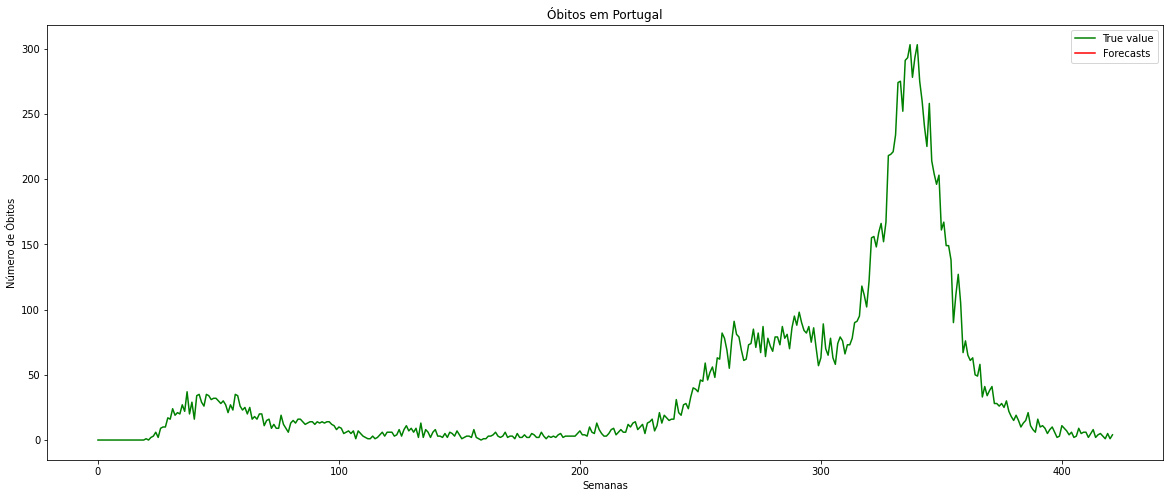

In [47]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  learning_rate = tunning_dict[t]['learning_rate']

  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size,learning_rate)
  path_to_save=r'modelo_'+str(t)+'.h5'
  model.save(path_to_save)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print('Previsões:')
  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [48]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [49]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.031370452642440795, 0.030440380970637004, 0.031370452642440795, 0.042616321705281734, 0.04210901752114296, 0.042616321705281734] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.04405270304530859, 0.04017130170017481, 0.044027314012249304, 0.054806704589476195, 0.04978511332844695, 0.05512541757896542] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.15432821345825992, 0.14547912897542117, 0.15446937032664815, 0.18757182102029524, 0.1751267196206997, 0.19060854171092312] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.02839239856435193, 0.02693807165034943, 0.02839239856435193, 0.0667684253046496, 0.06610560784012907, 0.0667684253046496] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.034010868947263115, 0.03044264126155112, 0.0339767963728971, 0.05899755788484105, 0.0544741748280

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.031370,0.030440,0.031370,0.042616,0.042109,0.042616
2,0.044053,0.040171,0.044027,0.054807,0.049785,0.055125
3,0.154328,0.145479,0.154469,0.187572,0.175127,0.190609
4,0.028392,0.026938,0.028392,0.066768,0.066106,0.066768
5,0.034011,0.030443,0.033977,0.058998,0.054474,0.060283
6,0.122296,0.113493,0.122296,0.159483,0.144919,0.162219
7,0.028437,0.026797,0.028437,0.048779,0.048081,0.048779
8,0.034669,0.031027,0.034664,0.052955,0.048600,0.053434
9,0.101146,0.092761,0.101069,0.139032,0.127409,0.139849


In [50]:
df.columns

Index(['confirmados_novos', 'recuperados', 'Temperature', 'Visibility',
       'total_testes', 'testes_pcr', 'testes_antigenio',
       'new_cases_per_million_Austria', 'new_deaths_per_million_Austria',
       'new_cases_per_million_Belgium', 'new_deaths_per_million_Belgium',
       'icu_patients_per_million_Belgium', 'hosp_patients_per_million_Belgium',
       'new_deaths_per_million_Bulgaria', 'new_cases_per_million_Canada',
       'new_deaths_per_million_Canada', 'icu_patients_per_million_Canada',
       'new_cases_per_million_Cyprus', 'new_deaths_per_million_Czechia',
       'hosp_patients_per_million_Czechia', 'new_cases_per_million_Denmark',
       'new_tests_per_thousand_Estonia', 'icu_patients_per_million_France',
       'new_cases_per_million_Georgia', 'new_cases_per_million_Germany',
       'new_deaths_per_million_Germany', 'icu_patients_per_million_Germany',
       'new_deaths_per_million_Hungary', 'hosp_patients_per_million_Hungary',
       'positive_rate_India', 'new_cases

In [51]:
#Results metrics to a file
final_df.to_csv(r"resultados_lstm_covid.csv",index=True)